here we want to look at the relationship between reads and UMIs for the cell barcodes from the 570-cell dropseq sample. Specifically, we believe that ambient barcodes may show a different amplification rate to true barcodes. Ideally we would assess this by alignment and then use our methods to identify the amplification rate accurately. However, it may be sufficient to obtain an estimate without alignment. To this end we need to extract a tally of UMI counts per cell.

In [1]:
import pyximport
pyximport.install(reload_support=True)
from umi_tools._dedup_umi import edit_distance
import umi_tools.umi_methods as umi_methods
import umi_tools.Utilities as U
import collections
import pandas as pd
import numpy as np
import pysam
import regex
import CGAT.Fastq as Fastq
import CGAT.IOTools as IOTools

%load_ext rpy2.ipython
%matplotlib inline  

In [4]:
hg_inbam = "../run/mapped/dropseq_mixed_species_hg38.bam"
mm_inbam = "../run/mapped/dropseq_mixed_species_mm10.bam"

In [5]:
fastq_infile = "../run/raw/dropseq_mixed_species.fastq.1.gz"
fastq_infile2 = "../run/raw/dropseq_mixed_species.fastq.2.gz"


In [22]:
def get_barcodes(read_name):
    cell, umi = read_name.split("_")[-2:]
    return cell, umi


hg_inbam = "../run/mapped/dropseq_mixed_species_hg38.bam"
mm_inbam = "../run/mapped/dropseq_mixed_species_mm10.bam"

def getCellUMIs(inbam):
    
    counts = collections.defaultdict(set)
    
    samfile = pysam.AlignmentFile(inbam, "rb")
    
    n = 0
    for read in samfile:
        n += 1
        if n % 5000000 == 0:
            print("processed %dM reads" % (n/1000000))
        cell, umi = get_barcodes(read.query_name)
        counts[cell].add(umi)
        
    
    print("processed %dM reads" % (float(n)/1000000))

    return counts
        
hg_counts = getCellUMIs(hg_inbam)
mm_counts = getCellUMIs(mm_inbam)
print(len(hg_counts))
print(len(mm_counts))

processed 5M reads
processed 10M reads
processed 15M reads
processed 15M reads
processed 5M reads
processed 9M reads
471653
326985


In [27]:
# extract UMI, cell and sequence qualities and derive cell and umi counts from fastqs

cell_umi_counts = collections.defaultdict(set)
cell_counts = collections.Counter()

qualities = collections.defaultdict(
    lambda: collections.defaultdict(collections.Counter))

ReadExtractor = umi_methods.ExtractFilterAndUpdate(
    method="string", pattern="CCCCCCCCCCCCNNNNNNNN", extract_cell=True)

read1s = umi_methods.fastqIterate(U.openFile(fastq_infile))
read2s = umi_methods.fastqIterate(U.openFile(fastq_infile2))

def phredToInt(phreds):
    return(list(map(lambda x: ord(x)-33, phreds)))

n = 0
for read1 in read1s:
    read2 = next(read2s)
    n += 1
    cell, umi, umi_quals, new_seq, new_quals, new_seq2, new_quals2 = ReadExtractor.getBarcodes(read1, None)
    
    cell_umi_counts[cell].add(umi)
    cell_counts[cell] += 1
    
    cell_quals = read1.quals[:12] # extractor doesn't extract the cell quals. grrrr...
    qualities[cell]['read'].update(phredToInt(read2.quals))
    qualities[cell]['cell'].update(phredToInt(cell_quals))
    qualities[cell]['umi'].update(phredToInt(umi_quals))
    
    if n % 5000000 == 0:
        print("processed %iM reads" % (float(n)/1000000))
        
    if n == 50000000:
        break

print("processed %iM reads" % (float(n)/1000000))

final_qualities = collections.defaultdict(lambda: collections.defaultdict(float))




processed 5M reads
processed 10M reads
processed 15M reads
processed 20M reads
processed 25M reads
processed 30M reads
processed 35M reads
processed 40M reads
processed 45M reads
processed 50M reads
processed 50M reads
defaultdict(<class 'float'>, {'cell': 37, 'read': 37, 'umi': 37})


In [57]:
def getCounterMean(counter):
    sum_of_numbers = sum([number*count for number, count in counter.most_common()])
    count = sum(count for n, count in counter.most_common())
    mean = sum_of_numbers / count
    return mean 

c = collections.Counter()
c.update((1,1,2,2,3,1,1,2,2,3,2))
print(c)
print(getCounterMean(c))

for cell in qualities:
    final_qualities[cell]['read'] = getCounterMean(qualities[cell]['read'])
    final_qualities[cell]['cell'] = getCounterMean(qualities[cell]['cell'])
    final_qualities[cell]['umi'] = getCounterMean(qualities[cell]['umi'])
   
print(final_qualities['AGCTATAGTGGG'])

Counter({2: 5, 1: 4, 3: 2})
1.8181818181818181
defaultdict(<class 'float'>, {'cell': 32.740286298568506, 'read': 28.6219836400818, 'umi': 35.173312883435585})


In [58]:
print(len(qualities))

print(qualities['AGCTATAGTGGG']['cell'])
print(qualities['AGCTATAGTGGG']['umi'])
print(qualities['AGCTATAGTGGG']['read'])
print(final_qualities['AGCTATAGTGGG'])

2106321
Counter({37: 898, 32: 795, 27: 126, 13: 66, 22: 39, 8: 32})
Counter({37: 1107, 32: 97, 13: 38, 27: 31, 22: 16, 8: 15})
Counter({37: 4352, 32: 1840, 13: 1303, 27: 928, 8: 845, 22: 512})
defaultdict(<class 'float'>, {'cell': 32.740286298568506, 'read': 28.6219836400818, 'umi': 35.173312883435585})


In [59]:
whitelist_infile = "../run/extract/dropseq_mixed_species_whitelist.tsv"

whitelist_counts = collections.Counter()
error2true = {}

with U.openFile(whitelist_infile) as inf:
    for line in inf:
        barcode, errors, count, error_counts = line.strip().split("\t")
        whitelist_counts[barcode] = count
        for error in errors.split(","):
            error2true[error] = barcode
        
print(len(whitelist_counts))

574


In [60]:
def checkError(barcode, whitelist):
    near_matches = set()
    comp_regex = regex.compile("(%s){e<=1}" % barcode)
    for whitelisted_barcode in whitelist:
        if barcode == whitelisted_barcode:
            continue
        if comp_regex.match(whitelisted_barcode):
            near_matches.add(whitelisted_barcode)
            if len(near_matches) > 1:
                return near_matches

    return near_matches


In [61]:
rows = []
n = 0
for cell in cell_umi_counts:
    
    if cell in error2true:
        e = True
        t = error2true[cell]
    else:
        e = False
        t = cell
    
    row = (cell, cell in whitelist_counts, e, t,
           cell_counts[cell], len(cell_umi_counts[cell]),
           1-(len(cell_umi_counts[cell])/cell_counts[cell]))
    
    rows.append(row)
    #if cell_counts[cell] != len(cell_umi_counts[cell]):
    if cell in whitelist_counts:
        n += 1
        if n < 30:
            print(row)
#print(cell_umi_counts)

('GGTGCGAGGTCT', True, False, 'GGTGCGAGGTCT', 16008, 8434, 0.4731384307846077)
('AGTTTATAGCAG', True, False, 'AGTTTATAGCAG', 37931, 16210, 0.5726450660409692)
('AACCGTCCACCT', True, False, 'AACCGTCCACCT', 62827, 25522, 0.5937733776879367)
('CGCACCTCGGAA', True, False, 'CGCACCTCGGAA', 63623, 21893, 0.6558948807821071)
('TCGGAGGCTATT', True, False, 'TCGGAGGCTATT', 60768, 23056, 0.620589784096893)
('ATAGTATAGACC', True, False, 'ATAGTATAGACC', 39973, 17421, 0.5641808220548871)
('CCACTCCCCCCT', True, False, 'CCACTCCCCCCT', 54057, 23703, 0.5615183972473501)
('CGTATGAAGGTC', True, False, 'CGTATGAAGGTC', 77462, 28467, 0.6325036792233611)
('CCGTTGCCCGTA', True, False, 'CCGTTGCCCGTA', 72594, 27455, 0.6218006997823511)
('CCTGTGGCTGGT', True, False, 'CCTGTGGCTGGT', 84915, 27915, 0.6712594947889066)
('CACTGGAACCCT', True, False, 'CACTGGAACCCT', 30057, 13987, 0.5346508300894965)
('GATCGTGTCTCC', True, False, 'GATCGTGTCTCC', 45564, 18768, 0.5880958651567026)
('AGGTTAAGCACT', True, False, 'AGGTTAAGCAC

In [62]:
duplication_df = pd.DataFrame.from_records(
    rows, columns=["cell", "whitelist", "error", "true_barcode", "count", "unique_umi_count", "dup._rate"])
print(duplication_df.head())
print(duplication_df.shape)
duplication_df = duplication_df[duplication_df['count']>10]
print(duplication_df.shape)

           cell whitelist  error  true_barcode  count  unique_umi_count  \
0  CCCGGCAAAGGA     False  False  CCCGGCAAAGGA      1                 1   
1  GAAAATCTGGGA     False  False  GAAAATCTGGGA      1                 1   
2  GTGCGGTCCTGG     False  False  GTGCGGTCCTGG      1                 1   
3  TATCTGACAGTC     False  False  TATCTGACAGTC      1                 1   
4  CAGAACGTAGGT     False  False  CAGAACGTAGGT      1                 1   

   dup._rate  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0  
(2106321, 7)
(143102, 7)


In [63]:
duplication_df['hg_reads'] = [len(hg_counts[x]) if x in hg_counts else 0 for x in duplication_df['cell']]
duplication_df['mm_reads'] = [len(mm_counts[x]) if x in hg_counts else 0 for x in duplication_df['cell']]
duplication_df['max_aligned_reads'] = duplication_df[['hg_reads', 'mm_reads']].apply(axis=1, func=max)
duplication_df['specificity'] = duplication_df[['hg_reads', 'mm_reads']].apply(
    axis=1, func=lambda x: max(x)/sum(x))

/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


In [64]:
# print duplication_df resticted to cells with specificity = NA and high counts
# check this exists in the input to hisat!!

tmp_df = duplication_df[duplication_df['specificity'].isnull()]
tmp_df = tmp_df[tmp_df['count']>100]
#tmp_df = tmp_df[tmp_df['error']==True]
tmp_df = tmp_df[tmp_df['dup._rate']<0.7]
print(tmp_df.head())

               cell whitelist  error  true_barcode  count  unique_umi_count  \
4622   GCTAAAGTATCC     False  False  GCTAAAGTATCC    118               117   
5340   AAAAAAATATAA     False  False  AAAAAAATATAA    263               239   
9035   ATAAACAAACCA     False  False  ATAAACAAACCA    161               160   
11113  AAAAAGAAAAAT     False  False  AAAAAGAAAAAT    113               113   
14013  AAAAAGAAACAA     False  False  AAAAAGAAACAA    111               104   

       dup._rate  hg_reads  mm_reads  max_aligned_reads  specificity  
4622    0.008475         0         0                  0          NaN  
5340    0.091255         0         0                  0          NaN  
9035    0.006211         0         0                  0          NaN  
11113   0.000000         0         0                  0          NaN  
14013   0.063063         0         0                  0          NaN  


In [65]:
whitelist = set(whitelist_counts.keys())
error = []
error_barcode = []

for barcode in duplication_df['cell']:
    barcode_errors = checkError(barcode, whitelist)
    if len(barcode_errors) == 1:
        error.append("Exactly 1")
        error_barcode.append(list(barcode_errors)[0])
    elif len(barcode_errors) > 1:
        error.append(">1")
        error_barcode.append(",".join(barcode_errors))
    else:
        error.append("None")
        error_barcode.append("")               
    
duplication_df['full_error'] = error
duplication_df['error_barcode'] = error_barcode

In [66]:
duplication_df['read_qual'] = [final_qualities[cell]['read'] for cell in duplication_df['cell']]
duplication_df['umi_qual'] = [final_qualities[cell]['umi'] for cell in duplication_df['cell']]
duplication_df['cell_qual'] = [final_qualities[cell]['cell'] for cell in duplication_df['cell']]

In [67]:
%%R -i duplication_df

library(ggplot2)
library(Hmisc)

print(head(duplication_df))


           cell whitelist error true_barcode count unique_umi_count dup._rate
10 AAGTAAAAACAT     FALSE FALSE AAGTAAAAACAT    32               32 0.0000000
29 ATAGACTGTCAC     FALSE FALSE ATAGACTGTCAC    20               10 0.5000000
37 AAATAATTATTA     FALSE FALSE AAATAATTATTA    25               24 0.0400000
45 GATAGACCCGAC     FALSE FALSE GATAGACCCGAC    15               15 0.0000000
62 GAACTNATCGCT     FALSE  TRUE GAACTCATCGCT    39               39 0.0000000
74 TACTACCGGAGC     FALSE FALSE TACTACCGGAGC    74               44 0.4054054
   hg_reads mm_reads max_aligned_reads specificity full_error error_barcode
10        2        1                 2   0.6666667       None              
29        0        0                 0         NaN       None              
37        0        0                 0         NaN       None              
45        1        0                 1   1.0000000       None              
62       24        2                24   0.9230769  Exactly 1  GAACTCATCGC

In [68]:
%%R
duplication_df$error[duplication_df$error==T] <- "1-edit error"
duplication_df$error[duplication_df$error==F] <- ">1-edit error"

duplication_df$whitelist[duplication_df$whitelist==T] <- "Above Knee"
duplication_df$whitelist[duplication_df$whitelist==F] <- "Below Knee"

duplication_df$full_error <- factor(duplication_df$full_error, levels=c("None", "Exactly 1", ">1"))

my_theme <- theme_bw() + theme(text=element_text(size=20), aspect.ratio=1)


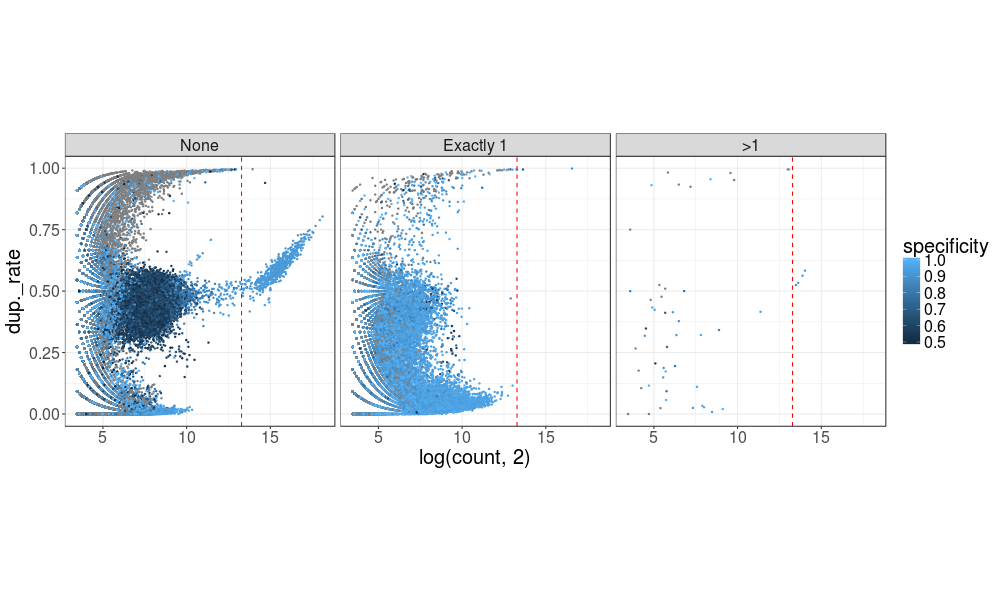

In [69]:
%%R -w 1000 -h 600
threshold = min(duplication_df[duplication_df$whitelist=="Above Knee", "count"])

p <- ggplot(duplication_df, aes(log(count,2), dup._rate, colour=specificity)) + geom_point(size=0.5) +
facet_grid(whitelist~error) + my_theme

#print(p)

p <- ggplot(duplication_df, aes(log(count,2), dup._rate, colour=specificity)) + geom_point(size=0.5) +
facet_grid(~full_error) + geom_vline(xintercept=log(threshold,2), colour="red", linetype=2) + my_theme 

print(p) 

           cell  whitelist         error true_barcode count unique_umi_count
10 AAGTAAAAACAT Below Knee >1-edit error AAGTAAAAACAT    32               32
29 ATAGACTGTCAC Below Knee >1-edit error ATAGACTGTCAC    20               10
37 AAATAATTATTA Below Knee >1-edit error AAATAATTATTA    25               24
45 GATAGACCCGAC Below Knee >1-edit error GATAGACCCGAC    15               15
62 GAACTNATCGCT Below Knee  1-edit error GAACTCATCGCT    39               39
74 TACTACCGGAGC Below Knee >1-edit error TACTACCGGAGC    74               44
   dup._rate hg_reads mm_reads max_aligned_reads specificity full_error
10 0.0000000        2        1                 2   0.6666667       None
29 0.5000000        0        0                 0         NaN       None
37 0.0400000        0        0                 0         NaN       None
45 0.0000000        1        0                 1   1.0000000       None
62 0.0000000       24        2                24   0.9230769  Exactly 1
74 0.4054054        2       1

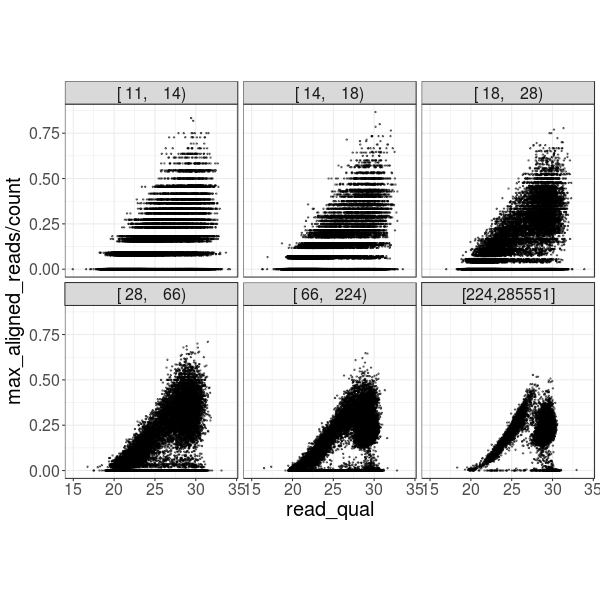

In [74]:
%%R -w 600 -h 600

duplication_df['counts_bin'] <- cut2(as.numeric(duplication_df$count), g=6)
print(head(duplication_df))
p <- ggplot(duplication_df, aes(read_qual, max_aligned_reads/count, group=read_qual)) +
geom_point(size=0.5, alpha=0.5) + geom_smooth(method="lm") +
facet_wrap(~counts_bin) +
my_theme 

print(p) 

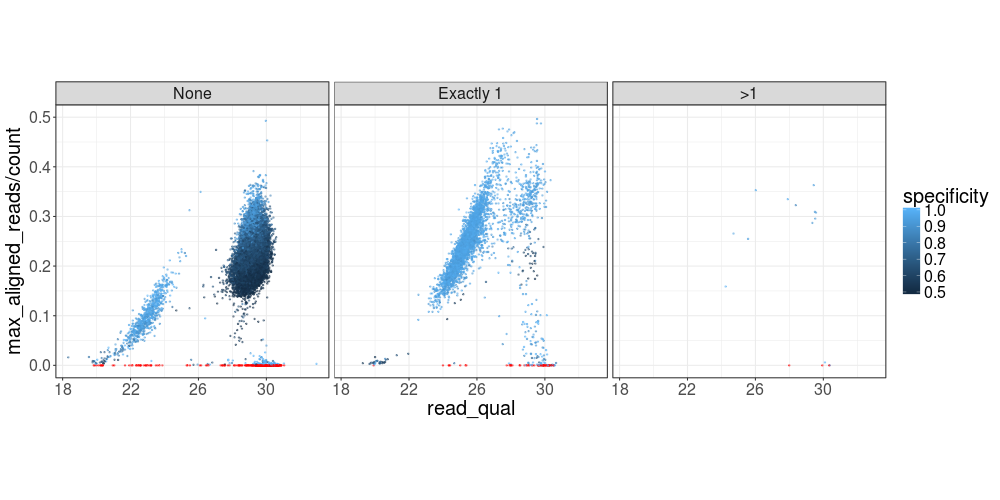

In [88]:
%%R -w 1000 -h 500
tmp_df <- duplication_df[duplication_df$counts_bin == "[224,285551]",]

p <- ggplot(tmp_df,
            aes(read_qual, max_aligned_reads/count, group=read_qual, colour=specificity)) +
geom_point(size=0.5, alpha=0.5) +
facet_wrap(~full_error) +
scale_y_continuous(limits=c(0,0.5))+
scale_colour_continuous(na.value="red") +
my_theme 

print(p) 

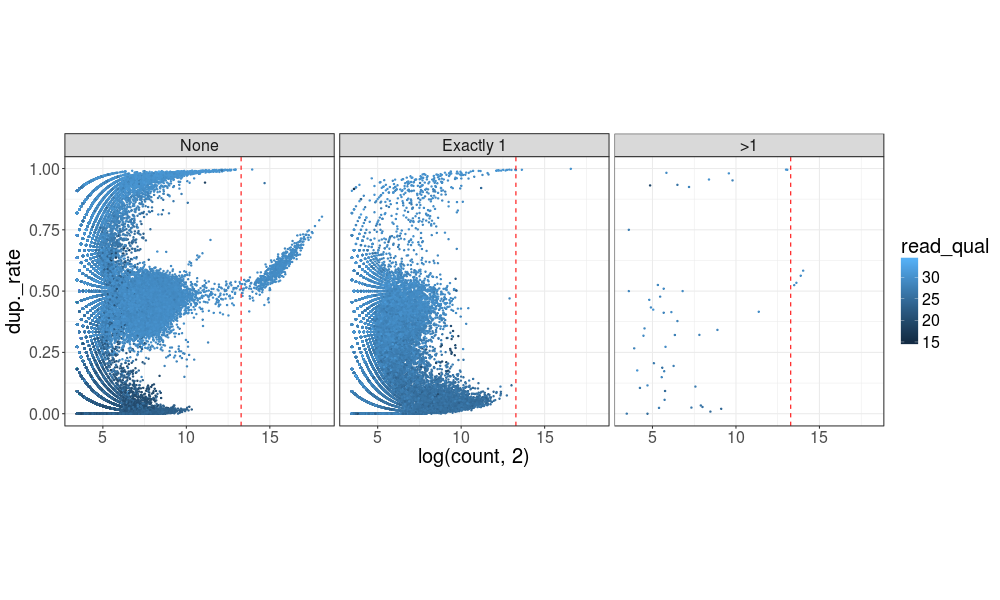

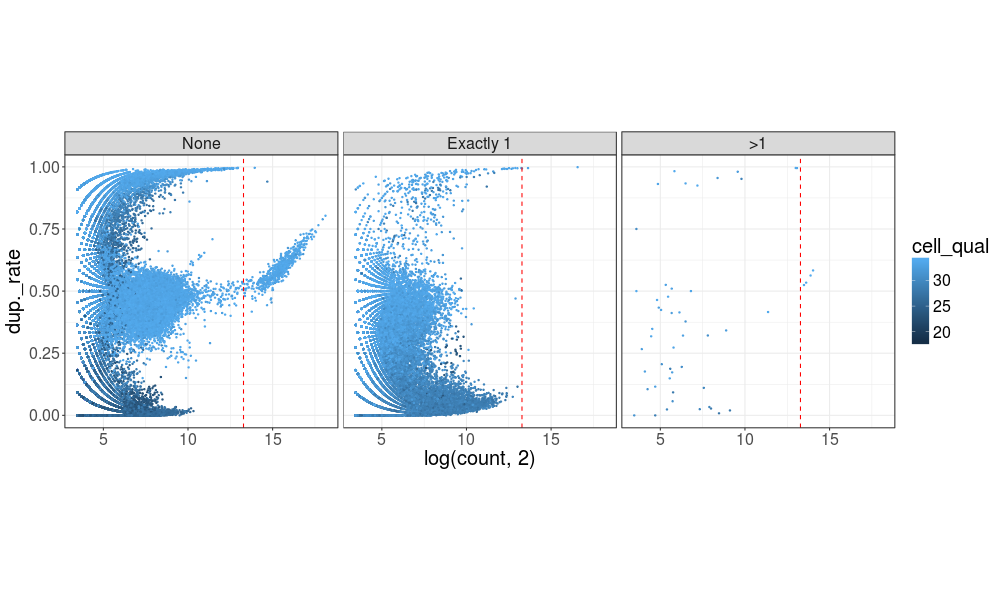

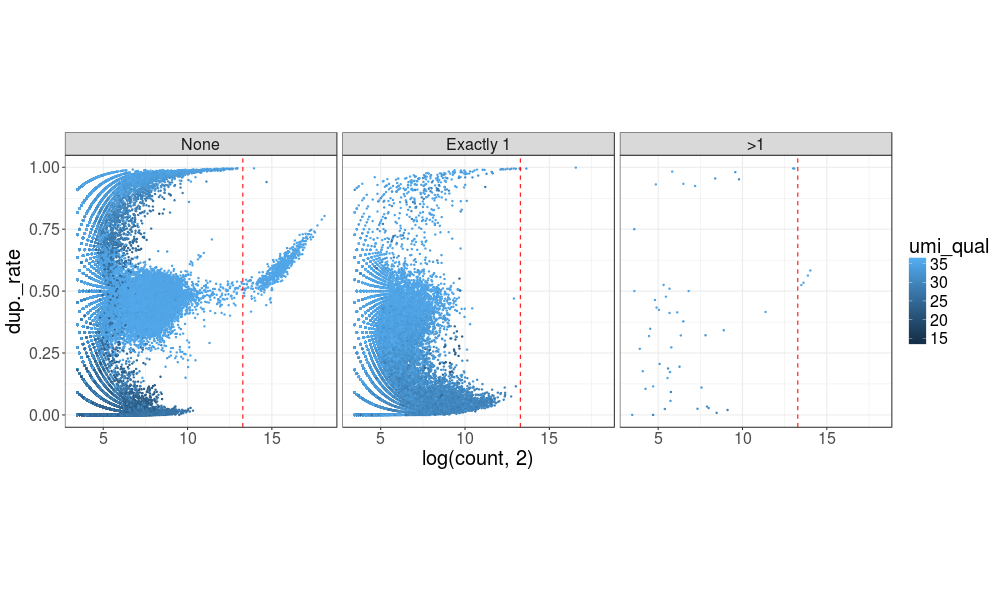

In [71]:
%%R -w 1000 -h 600
p <- ggplot(duplication_df, aes(log(count,2), dup._rate, colour=read_qual)) + geom_point(size=0.5) +
facet_grid(~full_error) + geom_vline(xintercept=log(threshold,2), colour="red", linetype=2) + my_theme 

print(p) 

p <- ggplot(duplication_df, aes(log(count,2), dup._rate, colour=cell_qual)) + geom_point(size=0.5) +
facet_grid(~full_error) + geom_vline(xintercept=log(threshold,2), colour="red", linetype=2) + my_theme 

print(p) 

p <- ggplot(duplication_df, aes(log(count,2), dup._rate, colour=umi_qual)) + geom_point(size=0.5) +
facet_grid(~full_error) + geom_vline(xintercept=log(threshold,2), colour="red", linetype=2) + my_theme 

print(p) 

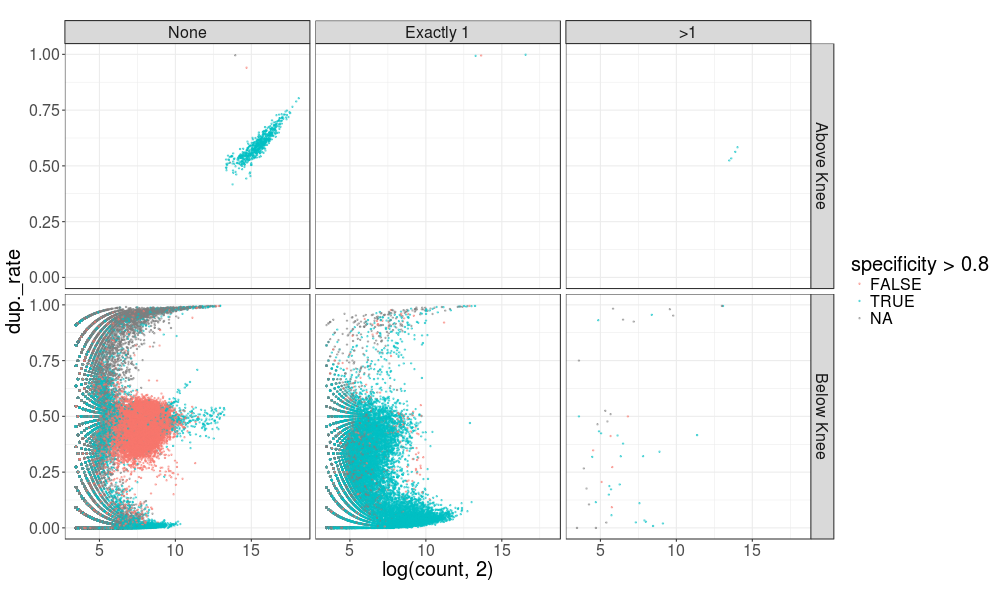

In [72]:
%%R -w 1000 -h 600
p <- ggplot(duplication_df, aes(log(count,2), dup._rate, colour=specificity>0.8)) +
geom_point(size=0.5, alpha=0.5) +
facet_grid(whitelist~full_error) + my_theme

print(p)

In [43]:
%%R
print(head(duplication_df[is.na(duplication_df$)])) 



Error in (function (file = "", n = NULL, text = NULL, prompt = "?", keep.source = getOption("keep.source"),  : 
  <text>:1:61: unexpected ')'
1: withVisible({print(head(duplication_df[is.na(duplication_df$)
                                                                ^


/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in (function (file = "", n = NULL, text = NULL, prompt = "?", keep.source = getOption("keep.source"),  : 
  <text>:1:61: unexpected ')'
1: withVisible({print(head(duplication_df[is.na(duplication_df$)
                                                                ^

  warnings.warn(x, RRuntimeWarning)


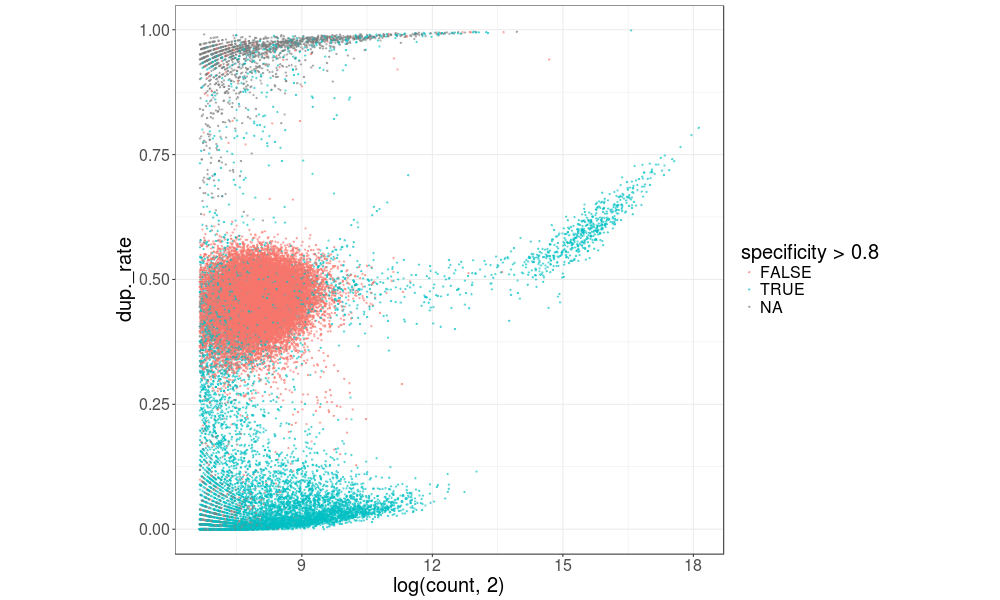

In [44]:
%%R -w 1000 -h 600
p <- ggplot(duplication_df[duplication_df$count>100,], aes(log(count,2), dup._rate, colour=specificity>0.8)) +
geom_point(size=0.5, alpha=0.5) + my_theme

print(p)

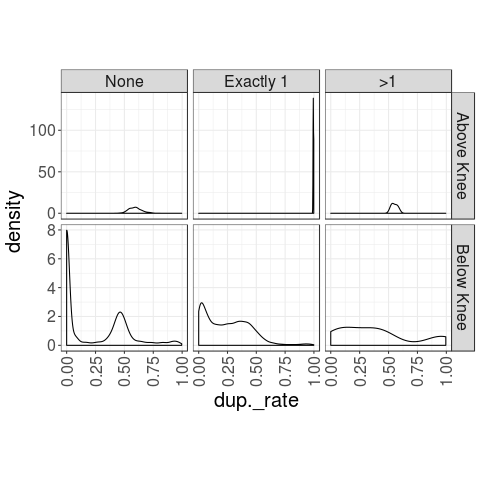

In [45]:
%%R
p <- ggplot(duplication_df, aes(dup._rate, colour=specificity)) + geom_density() +
facet_grid(whitelist~full_error, scale='free') + my_theme +
theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1))

print(p)